<a href="https://colab.research.google.com/github/chuks2324/Handwritten-Text-Recognition/blob/main/Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **NAME: CHUKWUDI AMUSHIE**
### **STUDENT NO: 18057021**
### **MODULE CODE: 6COM1054**
### **MODULE NAME: AI FINAL YEAR PROJECT**
### **HANDWRITTEN TEXT RECOGNITION USING NEURAL NETWORKS**

#####The project artifact is a Convolutional and recurrent Network model with Connectionist Temporal Classifcation (CTC) for loss and output.
#####The artifact is built using Keras library on TensorFlow.

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

#### **Get Dataset**

*   Unzip the dataset from google drive
*   Copy labels after unzip



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -qq /content/drive/My\ Drive/Dataset.zip

train = pd.read_csv('written_name_train_v2.csv')
test = pd.read_csv('written_name_test_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')

print(train.head())
print(train.tail())

Mounted at /content/drive
          FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE
                FILENAME       IDENTITY
330956  TRAIN_330957.jpg          LENNY
330957  TRAIN_330958.jpg        TIFFANY
330958  TRAIN_330959.jpg  COUTINHO DESA
330959  TRAIN_330960.jpg         MOURAD
330960  TRAIN_330961.jpg        HELOISE


#### **Filter out bad data**
#####Lets remove the NaN values from the labels. This includes the training, testing and validation set.
##### NaN is an abbreviation for *Not a Number* and represents rows with missing values.



In [ ]:
train.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
train.reset_index(inplace = True, drop=True)

Remove label values with the identity *UNREADABLE*. We can visualise some *UNREADABLE* values in the training image dataset

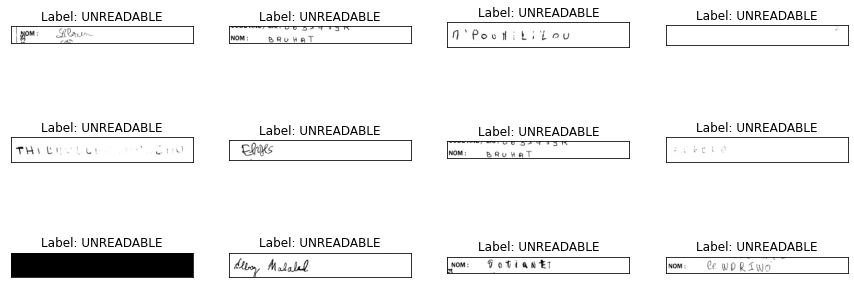

In [ ]:
import random
unreadable = train[train['IDENTITY'] == 'UNREADABLE'].index #return indices where data is unreadable

fig, axes = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(15, 6)
for i in range(12):
  plt.subplot(3, 4, i+1)
  index = random.choice(unreadable)
  imageName = train.iloc[index, 0]
  title = train.iloc[index,1]
  image = cv2.imread('train_v2/train/'+imageName, cv2.IMREAD_GRAYSCALE)
  plt.title(f"Label: {title}")
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image, 'gray')


Very Unreadable. Lets remove them from our labels and normalise the labels by setting them to upper case. Lastly, reset the indices again.

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

train.reset_index(inplace = True, drop=True) 
test.reset_index(inplace = True,drop=True)
valid.reset_index(inplace = True, drop=True)

#### **Pre-Processing Data**.

*   The labels needs to be represented as numbers for the CTC Loss function
*   The handwritten images will be scaled and rotated

*   The labels will be represented as numbers using the keras tokenizer library.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Find label with most characters
maxStr = 0
for x in train['IDENTITY']:
  if len(x)>maxStr:
    maxStr = len(x)
for x in test['IDENTITY']:
  if len(x)>maxStr:
    maxStr = len(x)
for x in valid['IDENTITY']:
  if len(x)>maxStr:
    maxStr = len(x)
print(maxStr) #most characters in any label

tokenizer = Tokenizer(num_words = maxStr, lower = False, char_level = True)#set lower to true to include lower case
tokenizer.fit_on_texts(train['IDENTITY'].values)

34


##### Function *sampleProcessing* handles pre-processing for input image and label


*  Reshapes the image by changing its dimensions (64 x 256)
*   Tokenizes labels

In [ ]:
imageHeigth = 256
imageWidth = 64

def sampleProcessing(imageName, identity):
  #reshape images
  image = cv2.imread(imageName , cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image,(imageHeigth, imageWidth), interpolation = cv2.INTER_AREA)
  image = cv2.bitwise_not(image)
  image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)/255
  
  #tokenize labels
  idSequence = tokenizer.texts_to_sequences([identity])
  identity = pad_sequences(idSequence, maxlen = maxStr, padding = 'post')[0]
  return image, identity

##### Lets Apply the data processing to training, test and validation set
##### 80000 train sets, 8000 validation sets and 8000 test sets from the original dataset will be used to train the model.

In [ ]:
train_size = 80000
valid_size= 8000
test_size = 8000

train_x = []
test_x = []
valid_x= []

train_y = []
test_y = []
valid_y = []

train_label_len = []
test_label_len = []
valid_label_len = []

for x in range(train_size):
  imageTrain, labelTrain = sampleProcessing('train_v2/train/'+train.iloc[ x, 0], train.iloc[ x, 1])
  train_label_len.append(len(train.iloc[ x, 1]))
  train_x.append(imageTrain)
  train_y.append(labelTrain)

for x in range(test_size):
  imageTest, labelTest = sampleProcessing('test_v2/test/'+test.iloc[ x, 0], test.iloc[ x, 1])
  test_label_len.append(len(test.iloc[ x, 1]))
  test_x.append(imageTest)
  test_y.append(labelTest)
    
for x in range(valid_size):
  imageValid, labelValid = sampleProcessing('validation_v2/validation/'+valid.iloc[ x, 0], valid.iloc[ x, 1])
  valid_label_len.append(len(valid.iloc[ x, 1]))
  valid_x.append(imageValid)
  valid_y.append(labelValid)
  
#convert to numpy arrays    
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)
train_label_len = np.array(train_label_len) #length of each label
test_label_len = np.array(test_label_len)
valid_label_len = np.array(valid_label_len)

In [ ]:
train_input_len = np.ones(train_size) * 62 #
valid_input_len = np.ones(valid_size) * 62
valid_output = np.zeros(valid_size) #
train_output = np.zeros([train_size]) # output for CTC Loss

#### **CTC Loss Function Definition**

In [ ]:
from keras import backend as K
def ctc_lambda_func(args):
    labels, y_pred, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

#### **Model Architecture**


In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
characters = set(char for label in train['IDENTITY'].values for char in label)

input_data = Input(shape=(256, 64, 1), name='input')
labels = Input(name='labels', shape=[maxStr], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

#CNN Block
network = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
network = BatchNormalization()(network)
network = Activation('relu')(network)
network = MaxPooling2D(pool_size=(2, 2), name='max1')(network)
network = Dropout(0.25)(network)

network = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(network)
network = BatchNormalization()(network)
network = Activation('relu')(network)
network = MaxPooling2D(pool_size=(2, 2), name='max2')(network)
network = Dropout(0.25)(network)

network = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(network)
network = BatchNormalization()(network)
network = Activation('relu')(network)
network = MaxPooling2D(pool_size=(1, 2), name='max3')(network)
network = Dropout(0.25)(network)
network = Reshape(target_shape=((64, 1024)), name='reshape')(network) #Dimensions from max pooling needed to set 'reshape' dimensions
network = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(network)

# RNN block
network = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(network)
network = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(network)

# Output
network = Dense(len(characters)+1, kernel_initializer='he_normal',name='dense2')(network)
y_pred = Activation('softmax', name='softmax')(network)

loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

#### **Training Process**
#### Model trained for 50 epochs and batch_size 110. 
#### Number of Iterations = 80000/110 = 728 iterations

In [ ]:
history = model.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                          validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                          epochs=40, batch_size=110)

Epoch 1/40
728/728 [==============================] - 134s 158ms/step - loss: 21.3366 - val_loss: 20.1450
Epoch 2/40
728/728 [==============================] - 112s 154ms/step - loss: 18.9562 - val_loss: 18.7735
Epoch 3/40
728/728 [==============================] - 113s 155ms/step - loss: 17.3472 - val_loss: 16.4850
Epoch 4/40
728/728 [==============================] - 113s 155ms/step - loss: 13.8892 - val_loss: 12.4346
Epoch 5/40
728/728 [==============================] - 113s 155ms/step - loss: 8.9505 - val_loss: 8.0498
Epoch 6/40
728/728 [==============================] - 113s 155ms/step - loss: 6.0033 - val_loss: 5.6225
Epoch 7/40
728/728 [==============================] - 113s 155ms/step - loss: 4.8160 - val_loss: 4.7063
Epoch 8/40
728/728 [==============================] - 113s 155ms/step - loss: 4.0656 - val_loss: 3.7215
Epoch 9/40
728/728 [==============================] - 113s 155ms/step - loss: 3.5415 - val_loss: 3.7478
Epoch 10/40
728/728 [==============================] - 1

###### Plot showing computed loss in training and validation data with each training Epoch

dict_keys(['loss', 'val_loss'])


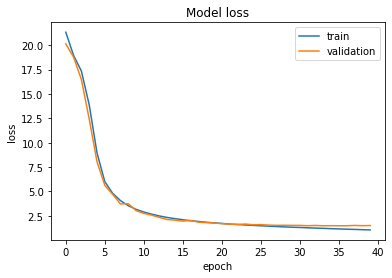

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
test_model = Model(inputs=input_data, outputs = y_pred)
test_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 dropout (Dropout)           (None, 128, 32, 32)       0         
                                                           

Function to Decode predictions i.e sequence to text

In [ ]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :maxStr]
    output_text = []
    for tokens in results:
      decoded = tokenizer.sequences_to_texts([tokens.numpy()])
      for x in decoded:
        seq_no_spaces = [text[::2] for text in decoded]# remove spaces from tokenization
      output_text.append(seq_no_spaces)
    return output_text

In [ ]:
encodePreds = test_model.predict(test_x)
decodedPreds = decode_predictions(encodePreds)

#### **Evaluation of Results of Test Dataset**
#####  Character Accuracy : The number of matches is divided by the size of the test data set to obtained an accuracy measure.

In [ ]:
import string
count = 0
for i in range(test_size):
  if (decodedPreds[i][0]) == (test.iloc[i, 1]):
    count+=1
accuracy = count/test_size*100
print("Word accuracy is :", accuracy)     


Word accuracy is : 76.85


#### **View Prediction on Test dataset**

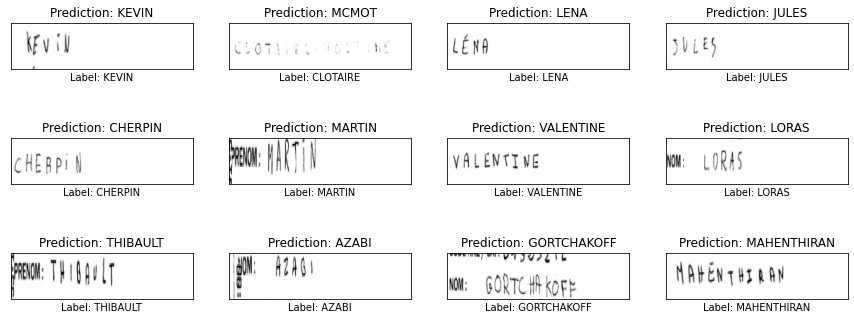

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(15, 6)
for i in range(12):
  plt.subplot(3, 4, i+1)
  image = test_x[i]
  image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
  title = f"Prediction: {decodedPreds[i][0]}"
  plt.imshow(image, 'gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f"Label: {test.iloc[i, 1]}")
  plt.title(title)

##### Let us view some misclassifications on test dataset
##### Label with index 500, 507 and 541 appear to have been classified currently but incorrectly labelled. May be true for more data.

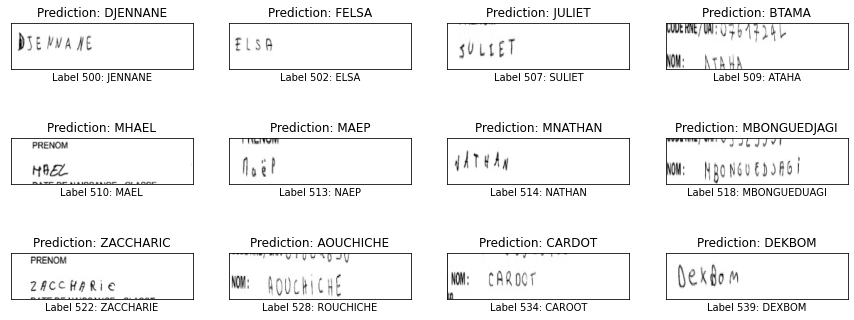

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(15, 6)
count=0
for i in range(test_size):
  if count < 12:
    if (decodedPreds[i+500][0]) != (test.iloc[i+500, 1]):
      plt.subplot(3, 4, count+1)
      im = test_x[i+500]
      im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
      plt.imshow(im, 'gray')
      title = f"Prediction: {decodedPreds[i+500][0]}"
      true = f"Label {i+500}: {test.iloc[i+500, 1]}"
      plt.xticks([])
      plt.yticks([])
      plt.xlabel(true)
      plt.title(title)
      count +=1

Test for other jpg by users of model

/content/drive/My Drive


Text(0.5, 1.0, 'BAANUK')

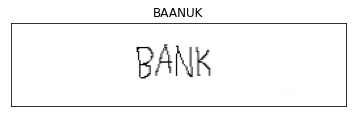

In [ ]:
filename = "test proj"
test_images = []
%cd /content/drive/My Drive/
in_image = cv2.imread(filename +".jpg", cv2.IMREAD_GRAYSCALE) #rename file test name.jpg to file on google drive.

in_image = cv2.resize(in_image,(imageHeigth, imageWidth), interpolation = cv2.INTER_AREA)
#in_image = cv2.bitwise_not(in_image)
in_image = cv2.rotate(in_image, cv2.ROTATE_90_CLOCKWISE)/255

in_image = in_image.astype('float')  
test_images.append(in_image)

test_images = np.array(test_images)
new_test = test_model.predict(test_images)
new_test_decoded = decode_predictions(new_test)
in_image = cv2.rotate(in_image, cv2.ROTATE_90_COUNTERCLOCKWISE)/255
plt.xticks([])
plt.yticks([])
plt.imshow(in_image, 'gray')
plt.title(new_test_decoded[0][0])